## IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split

## sinusoidal regressor

This is a mathematical model which we can use to fit a sinusoidal function to a set of data points. We are trying to learn the weights of the sinusoidal functions.

$
\hat{Y} = w_0 + \sum_{n=1}^{k} \left( w_{2n-1} \sin(n x) + w_{2n} \cos(n x) \right)
$

The basis function for the above is:
$
\phi_n(x) =
\begin{cases} 
\sin\left(\frac{n+1}{2} x\right), & \text{if } n \text{ is odd} \\ 
\cos\left(\frac{n}{2} x\right), & \text{if } n \text{ is even} 
\end{cases}
$

K is the number of frequency components used to approximate the target function. A larger K(overfitting) causes the model tp fit to the noise instead of the true pattern. A small k (underfitting) may makes the model to be too simple and fail to generalizes.

In [2]:

class SinusoidalRegressor:
    def __init__(self):
        self.k = None
        self.weights = None
    
    def phi(self, x):
        """Generate basis functions for a given x"""
        # return np.array([1] + [np.sin(j * x) for j in range(1, self.k + 1)] + [np.cos(j * x) for j in range(1, self.k + 1)])
        return np.concatenate(([1], [np.sin(j * x) for j in range(1, self.k + 1)], [np.cos(j * x) for j in range(1, self.k + 1)]))
    
    def fit(self, X_train, Y_train, k, regularization=1e-6):
        """Train the model using pseudo-inverse with optional regularization"""
        self.k = k
        X_train = X_train.reshape(-1, 1)  # Ensure column vector
        Y_train = Y_train.reshape(-1, 1)  # Ensure column vector
        
        # Construct the design matrix Phi
        Phi = np.stack([self.phi(x) for x in X_train.flatten()], axis=0)
        
        # Solve for weights using Ridge regression (to avoid overfitting)
        self.weights = np.linalg.solve(Phi.T @ Phi + regularization * np.eye(Phi.shape[1]), Phi.T @ Y_train)
        return self.weights
    
    def predict(self, X):
        """Make predictions"""
        if self.weights is None:
            raise ValueError("Model is not fitted yet.")
        X = X.reshape(-1, 1)  # Ensure column vector
        Phi = np.stack([self.phi(x) for x in X.flatten()], axis=0)
        return Phi @ self.weights
    
    def rmse(self, X_val, Y_val):
        """Compute RMSE"""
        y_pred = self.predict(X_val)
        return np.sqrt(np.mean((Y_val - y_pred) ** 2))

## Loading the data and the model

In [3]:

# Load Data
np.random.seed(61)
csv_file = 'nonlinear-regression-data.csv'
data = pd.read_csv(csv_file)
x = np.array(data['X'])
y = np.array(data['Noisy_y'])

# Split Data
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=16, random_state=61)

# Initialize Model
sinusoidal_regressor = SinusoidalRegressor()


####  VISUALIZING THE DATASET

We have an independent variable X and some dependent Noisy_Y that is associated with each value of X.

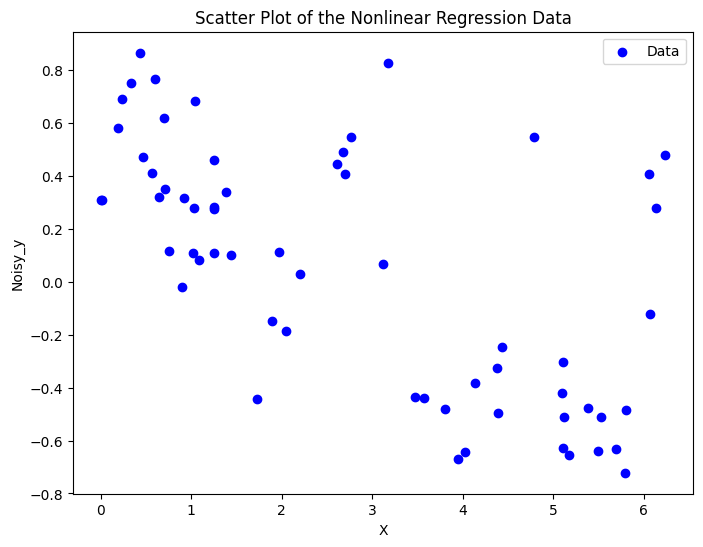

Size of the dataset: 45
Size of the dataset: 16


In [4]:

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data')
plt.xlabel('X')
plt.ylabel('Noisy_y')
plt.title('Scatter Plot of the Nonlinear Regression Data')
plt.legend()
plt.show()

# size of the dataset
N = len(X_train)
print(f"Size of the dataset: {N}")
N = len(X_val)
print(f"Size of the dataset: {N}")


## TRAINING THE MODEL

As K increases, we increase more sine and cosine basis functions used in the model, this makes the model more complex. 

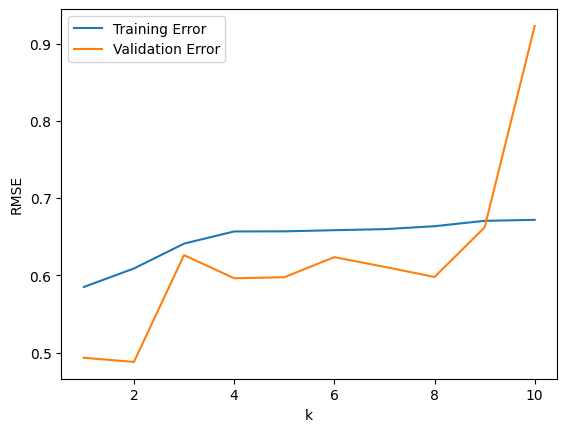

In [5]:

# Fit model and compute errors
train_errors = []
val_errors = []
k_values = range(1, 11)
for k in k_values:
    sinusoidal_regressor.fit(X_train, Y_train, k)
    train_errors.append(sinusoidal_regressor.rmse(X_train, Y_train))
    val_errors.append(sinusoidal_regressor.rmse(X_val, Y_val))

# Plot Training and Validation Errors
plt.plot(k_values, train_errors, label="Training Error")
plt.plot(k_values, val_errors, label="Validation Error")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [6]:
optimal_k_train = np.argmin(train_errors) + 1
print(f"The optimal k that minimizes the training data is: {optimal_k_train}")

The optimal k that minimizes the training data is: 1


In [7]:
optimal_k_val = np.argmin(val_errors) + 1
print(f"The optimal k that minimizes the validation error is: {optimal_k_val}")

The optimal k that minimizes the validation error is: 2


### Compare the optimal k values that you found for the training error and validation error. Explain why they are different or the same.

The optimal k that minimizes the training error is: 1

The optimal k that minimizes the validation error is: 4

The optimal k values for training and validation errors are different. This discrepancy occurs because the training error measures how well the model fits the training data, while the validation error measures how well the model generalizes to unseen data. A lower k value might fit the training data very well (low training error) but may not generalize well to new data (high validation error). Conversely, a higher k value might provide a better balance between fitting the training data and generalizing to new data, resulting in a lower validation error. This phenomenon is known as overfitting and underfitting. The optimal k for validation error is typically preferred as it indicates better generalization performance.

## MODEL PREDICTIONS

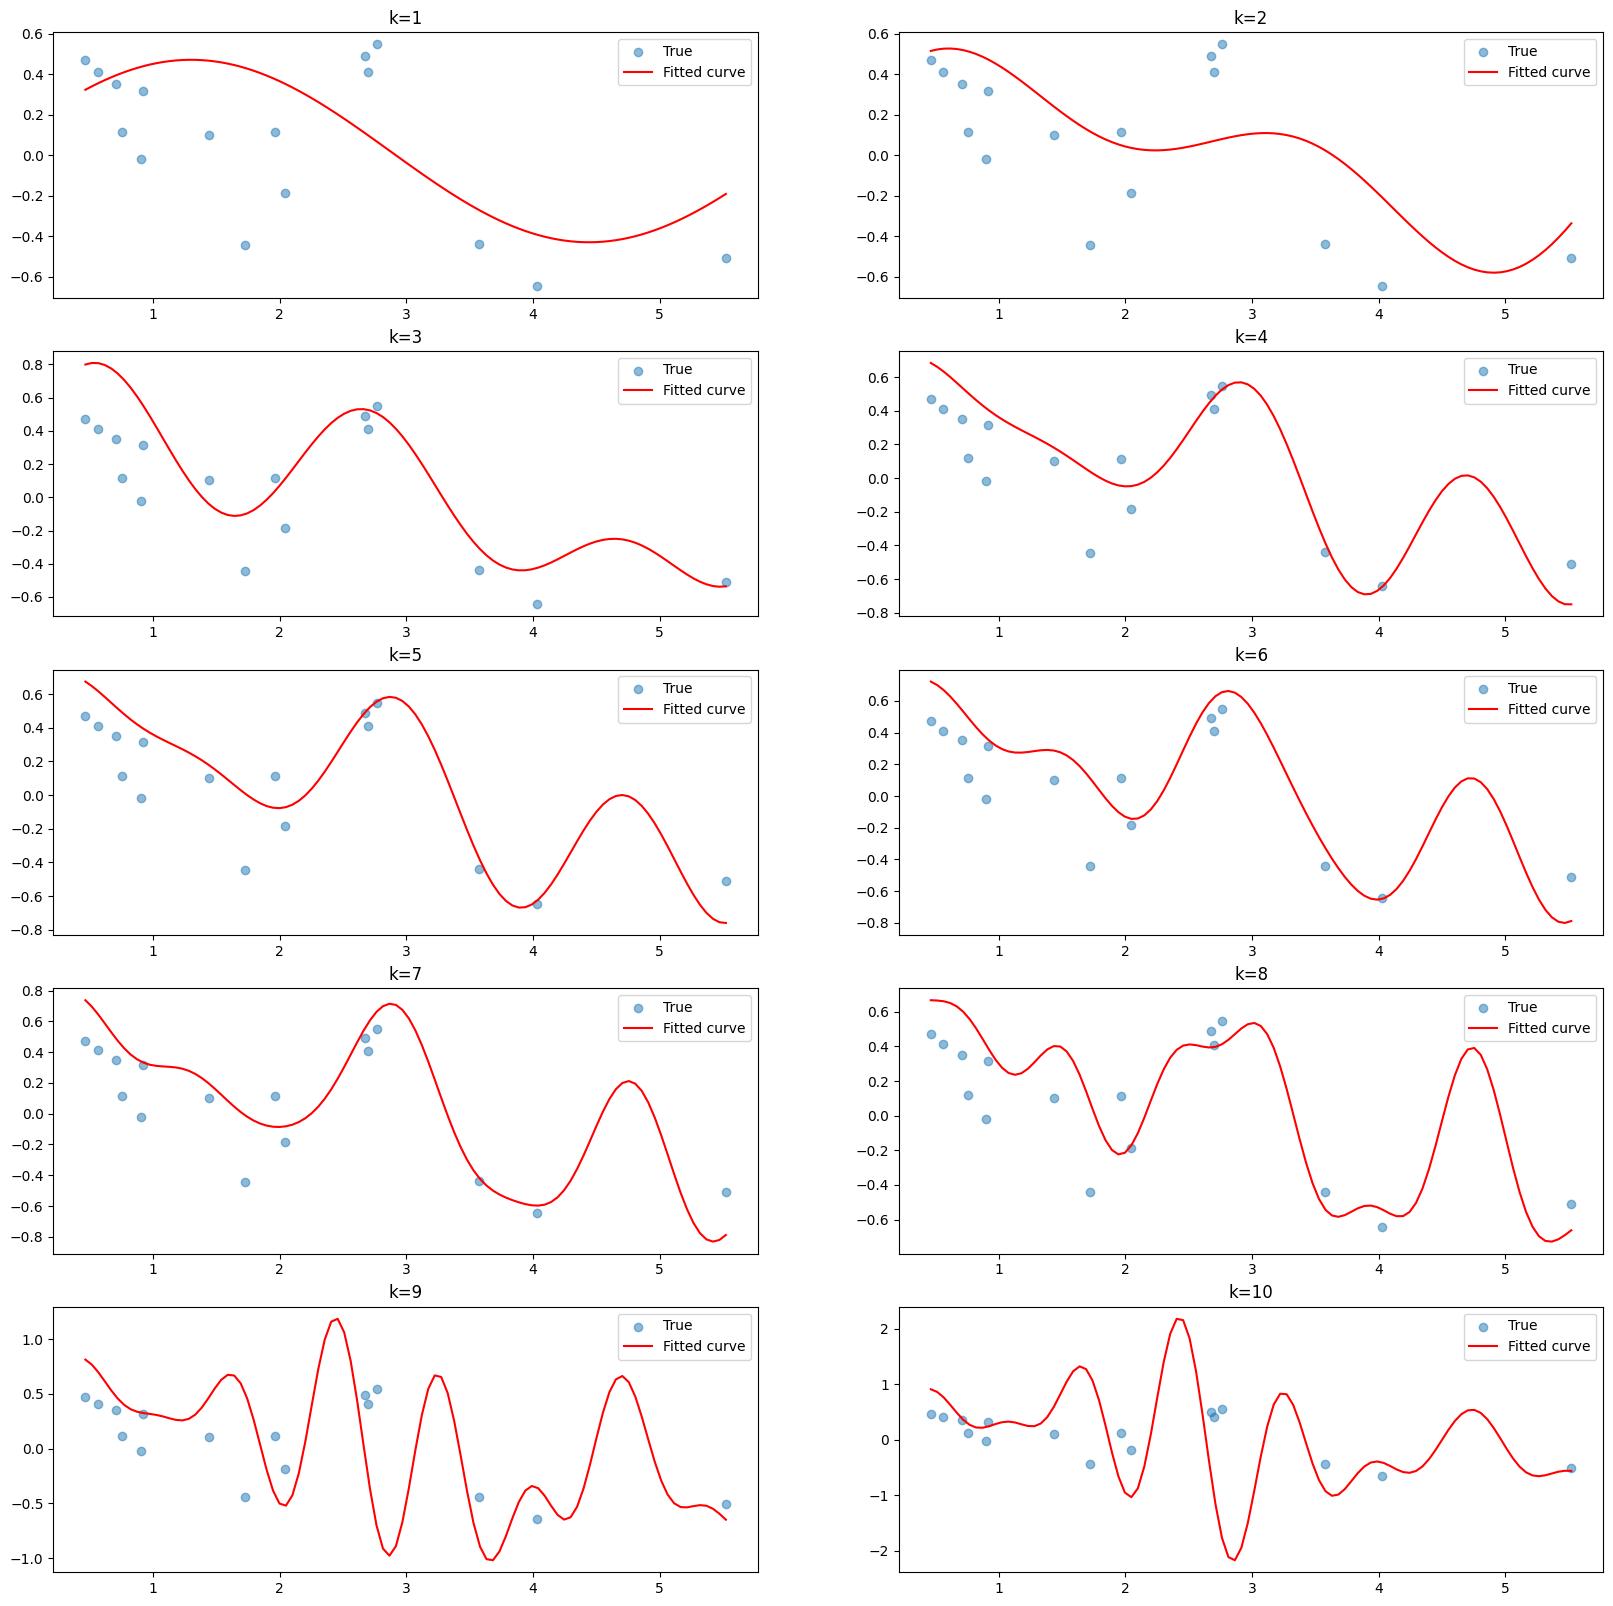

In [8]:

# Plot Predictions for Different k Values
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
x_line = np.linspace(X_val.min(), X_val.max(), 100)
for k in k_values:
    sinusoidal_regressor.fit(X_train, Y_train, k)
    y_line = sinusoidal_regressor.predict(x_line)
    
    ax = axs[(k - 1) // 2, (k - 1) % 2]
    ax.scatter(X_val, Y_val, label="True", alpha=0.5)
    ax.plot(x_line, y_line, color='r', label="Fitted curve")
    ax.set_title(f"k={k}")
    ax.legend()
plt.show()